# Figure 1: Modularity 𝑄 decreases as the Watts–Strogatz rewiring probability 𝑝 increases

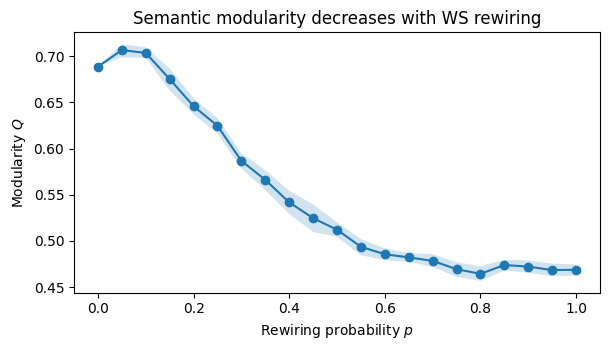


=== Saved outputs ===
Figure: outputs\modularity_vs_p.pdf
Table:  outputs\modularity_by_p_summary.csv

=== Per-p summary (for captions) ===
   p  n     mean  ci95_lo  ci95_hi
0.00 15 0.688800 0.688800 0.688800
0.05 15 0.706606 0.698884 0.713080
0.10 15 0.703602 0.698178 0.709718
0.15 15 0.675283 0.662949 0.686766
0.20 15 0.645908 0.637133 0.654521
0.25 15 0.624668 0.616164 0.632989
0.30 15 0.586735 0.578521 0.594912
0.35 15 0.566125 0.554942 0.576698
0.40 15 0.541812 0.529269 0.554374
0.45 15 0.524618 0.509815 0.539620
0.50 15 0.512175 0.504422 0.520183
0.55 15 0.493619 0.484430 0.502027
0.60 15 0.485593 0.479123 0.491987
0.65 15 0.482175 0.477316 0.486925
0.70 15 0.478439 0.471882 0.485538
0.75 15 0.469432 0.461107 0.476959
0.80 15 0.464383 0.456742 0.472600
0.85 15 0.473903 0.467977 0.479582
0.90 15 0.472227 0.465634 0.478798
0.95 15 0.468448 0.461861 0.475501
1.00 15 0.468772 0.462373 0.474459

=== Key paper metrics ===
Spearman rho (p vs Q): rho=-0.9232, p=4.63e-132
Kendall tau (p

In [1]:
import json
import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


# ----------------------------
# 0) Paths
# ----------------------------
DATA_DIR = Path("data")
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

JSON_PATH = DATA_DIR / "fig1.json"  # <-- change filename as needed


# ----------------------------
# 1) Load JSON
# ----------------------------
with open(JSON_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

mod_by_p = data["steps"]["ws_baseline"]["modularity_by_p"]  # dict: p(str) -> list[float]


# ----------------------------
# 2) Helpers: bootstrap CI
# ----------------------------
def bootstrap_ci(x, stat_fn=np.mean, n_boot=5000, alpha=0.05, seed=0):
    """
    Percentile bootstrap CI for a statistic (default mean).
    Returns (stat, lo, hi).
    """
    x = np.asarray(x, dtype=float)
    rng = np.random.default_rng(seed)
    n = len(x)
    boots = np.empty(n_boot, dtype=float)
    for b in range(n_boot):
        sample = rng.choice(x, size=n, replace=True)
        boots[b] = stat_fn(sample)
    lo = np.quantile(boots, alpha / 2)
    hi = np.quantile(boots, 1 - alpha / 2)
    return float(stat_fn(x)), float(lo), float(hi)


def boot_diff(a, b, n_boot=5000, alpha=0.05, seed=42):
    """
    Percentile bootstrap CI for mean(a) - mean(b).
    Returns (diff, lo, hi).
    """
    rng = np.random.default_rng(seed)
    a = np.asarray(a, float)
    b = np.asarray(b, float)
    na, nb = len(a), len(b)
    diffs = np.empty(n_boot, dtype=float)
    for i in range(n_boot):
        sa = rng.choice(a, size=na, replace=True)
        sb = rng.choice(b, size=nb, replace=True)
        diffs[i] = np.mean(sa) - np.mean(sb)
    diff = float(np.mean(a) - np.mean(b))
    lo = float(np.quantile(diffs, alpha / 2))
    hi = float(np.quantile(diffs, 1 - alpha / 2))
    return diff, lo, hi


def cohens_d_unpaired(a, b):
    a = np.asarray(a, float)
    b = np.asarray(b, float)
    na, nb = len(a), len(b)
    sa2 = np.var(a, ddof=1)
    sb2 = np.var(b, ddof=1)
    sp = math.sqrt(((na - 1) * sa2 + (nb - 1) * sb2) / (na + nb - 2))
    return float((np.mean(a) - np.mean(b)) / sp)


# ----------------------------
# 3) Tidy into a dataframe (one row per (p, replicate))
# ----------------------------
rows = []
for p_str, vals in mod_by_p.items():
    p = float(p_str)
    for v in vals:
        rows.append({"p": p, "modularity": float(v)})
df = pd.DataFrame(rows).sort_values(["p", "modularity"]).reset_index(drop=True)

# Summary by p: mean + 95% CI (bootstrap)
summary = []
for p, g in df.groupby("p", sort=True):
    vals = g["modularity"].to_numpy()
    mean, lo, hi = bootstrap_ci(vals, stat_fn=np.mean, n_boot=5000, alpha=0.05, seed=42)
    summary.append(
        {
            "p": p,
            "n": len(vals),
            "mean": mean,
            "sd": float(np.std(vals, ddof=1)) if len(vals) > 1 else 0.0,
            "sem": float(stats.sem(vals)) if len(vals) > 1 else 0.0,
            "ci95_lo": lo,
            "ci95_hi": hi,
            "median": float(np.median(vals)),
            "iqr": float(np.subtract(*np.quantile(vals, [0.75, 0.25]))),
        }
    )
summ = pd.DataFrame(summary).sort_values("p").reset_index(drop=True)


# ----------------------------
# 4) Plot: mean modularity vs p with 95% CI (PDF only)
# ----------------------------
x = summ["p"].to_numpy()
y = summ["mean"].to_numpy()
ylo = summ["ci95_lo"].to_numpy()
yhi = summ["ci95_hi"].to_numpy()

plt.figure(figsize=(6.2, 3.6))
plt.plot(x, y, marker="o", linewidth=1.5)
plt.fill_between(x, ylo, yhi, alpha=0.2)
plt.xlabel("Rewiring probability $p$")
plt.ylabel("Modularity $Q$")
plt.title("Semantic modularity decreases with WS rewiring")
plt.tight_layout()

fig_pdf = OUT_DIR / "modularity_vs_p.pdf"
plt.savefig(fig_pdf, dpi=300, bbox_inches="tight")  # dpi is harmless for PDF; keeps consistency
plt.show()


# ----------------------------
# 5) Paper-ready metrics (for your “X” placeholders)
# ----------------------------
# A) Monotonic association: p vs modularity (across all replicates)
rho_all, pval_rho_all = stats.spearmanr(df["p"], df["modularity"])
tau_all, pval_tau_all = stats.kendalltau(df["p"], df["modularity"])

# B) Linear trend summary: modularity ~ p
lin = stats.linregress(df["p"], df["modularity"])
beta = lin.slope
intercept = lin.intercept
r = lin.rvalue
r2 = r**2
pval_beta = lin.pvalue
se_beta = lin.stderr

# 95% CI for slope (t-based)
n = len(df)
dfree = n - 2
tcrit = stats.t.ppf(0.975, dfree)
beta_ci = (beta - tcrit * se_beta, beta + tcrit * se_beta)

# C) Endpoint contrast: p=0 vs p=1 (means, CIs, effect size)
p_min = float(df["p"].min())
p_max = float(df["p"].max())
vals_p0 = df.loc[df["p"] == p_min, "modularity"].to_numpy()
vals_p1 = df.loc[df["p"] == p_max, "modularity"].to_numpy()

mean0, lo0, hi0 = bootstrap_ci(vals_p0, n_boot=5000, alpha=0.05, seed=42)
mean1, lo1, hi1 = bootstrap_ci(vals_p1, n_boot=5000, alpha=0.05, seed=42)
diff01, diff01_lo, diff01_hi = boot_diff(vals_p0, vals_p1, n_boot=5000, alpha=0.05, seed=42)
d01 = cohens_d_unpaired(vals_p0, vals_p1)

# D) Optional nonlinearity check on per-p means (AIC linear vs quadratic)
p_means = summ[["p", "mean"]].copy()
X1 = np.vstack([np.ones(len(p_means)), p_means["p"].to_numpy()]).T
X2 = np.vstack([np.ones(len(p_means)), p_means["p"].to_numpy(), (p_means["p"].to_numpy() ** 2)]).T
y_means = p_means["mean"].to_numpy()

b1, *_ = np.linalg.lstsq(X1, y_means, rcond=None)
b2, *_ = np.linalg.lstsq(X2, y_means, rcond=None)
res1 = y_means - X1 @ b1
res2 = y_means - X2 @ b2
sse1 = float(np.sum(res1**2))
sse2 = float(np.sum(res2**2))

def aic(sse, k, n):
    return n * np.log(sse / n) + 2 * k

aic_lin = aic(sse1, k=2, n=len(y_means))
aic_quad = aic(sse2, k=3, n=len(y_means))


# ----------------------------
# 6) Outputs: table + console print
# ----------------------------
summ_csv = OUT_DIR / "modularity_by_p_summary.csv"
summ.to_csv(summ_csv, index=False)

print("\n=== Saved outputs ===")
print(f"Figure: {fig_pdf}")
print(f"Table:  {summ_csv}")

print("\n=== Per-p summary (for captions) ===")
print(summ[["p", "n", "mean", "ci95_lo", "ci95_hi"]].to_string(index=False))

print("\n=== Key paper metrics ===")
print(f"Spearman rho (p vs Q): rho={rho_all:.4f}, p={pval_rho_all:.3g}")
print(f"Kendall tau (p vs Q):  tau={tau_all:.4f}, p={pval_tau_all:.3g}")
print(f"Linear trend Q~p: beta={beta:.6f} (95% CI [{beta_ci[0]:.6f}, {beta_ci[1]:.6f}]), p={pval_beta:.3g}, R^2={r2:.4f}")
print(f"Endpoints: mean Q(p={p_min:g})={mean0:.4f} (95% CI [{lo0:.4f}, {hi0:.4f}])")
print(f"          mean Q(p={p_max:g})={mean1:.4f} (95% CI [{lo1:.4f}, {hi1:.4f}])")
print(f"          diff (p_min - p_max)={diff01:.4f} (95% CI [{diff01_lo:.4f}, {diff01_hi:.4f}]), Cohen's d={d01:.3f}")
print(f"Nonlinearity check (per-p means): AIC linear={aic_lin:.3f}, AIC quadratic={aic_quad:.3f} (lower is better)")


# Figure 2: Semantic modularity constrains exploratory access.

In [2]:
# ------------------------------------------------------------
# Experiment B: Modularity -> Creative exploration
# Loads JSON from data/, saves PDFs + metrics to outputs/
# ------------------------------------------------------------

import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import TheilSenRegressor

# ----------------------------
# CONFIG
# ----------------------------
DATA_DIR = Path("data")
OUT_DIR = Path("outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Change this to your actual filename in data/
JSON_FILENAME = "fig2.json"

# Figure filenames
FIG_MAIN_PDF = OUT_DIR / "expB_modularity_vs_num_concepts.pdf"
FIG_DIAM_PDF = OUT_DIR / "expB_modularity_vs_diameter.pdf"  # optional but useful
METRICS_JSON = OUT_DIR / "expB_metrics.json"
TABLE_CSV = OUT_DIR / "expB_summary_table.csv"

RANDOM_SEED = 42
BOOTSTRAP_B = 5000
ALPHA = 0.05  # for 95% CI

np.random.seed(RANDOM_SEED)

# ----------------------------
# HELPERS
# ----------------------------
def fisher_r_ci(r: float, n: int, alpha: float = 0.05):
    """95% CI for Pearson r via Fisher z-transform."""
    # Guard against numerical issues at |r|=1
    r = np.clip(r, -0.999999, 0.999999)
    z = np.arctanh(r)
    se = 1.0 / np.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha / 2)
    lo = np.tanh(z - z_crit * se)
    hi = np.tanh(z + z_crit * se)
    return lo, hi

def bootstrap_ci_stat(x, y, stat_fn, B=5000, alpha=0.05, seed=42):
    """Bootstrap CI for a statistic stat_fn(x, y) with paired resampling."""
    rng = np.random.default_rng(seed)
    n = len(x)
    stats_bs = np.empty(B, dtype=float)
    idx = np.arange(n)
    for b in range(B):
        samp = rng.choice(idx, size=n, replace=True)
        stats_bs[b] = stat_fn(x[samp], y[samp])
    lo = np.quantile(stats_bs, alpha/2)
    hi = np.quantile(stats_bs, 1 - alpha/2)
    return lo, hi

def bootstrap_ci_mean_diff(a, b, B=5000, alpha=0.05, seed=42):
    """Bootstrap CI for mean(a)-mean(b) with independent resampling within groups."""
    rng = np.random.default_rng(seed)
    a = np.asarray(a); b = np.asarray(b)
    na, nb = len(a), len(b)
    diffs = np.empty(B, dtype=float)
    for i in range(B):
        a_s = rng.choice(a, size=na, replace=True)
        b_s = rng.choice(b, size=nb, replace=True)
        diffs[i] = a_s.mean() - b_s.mean()
    lo = np.quantile(diffs, alpha/2)
    hi = np.quantile(diffs, 1 - alpha/2)
    return lo, hi

def ols_fit(y, X_df):
    """OLS with intercept; returns fitted model."""
    X = sm.add_constant(X_df, has_constant="add")
    return sm.OLS(y, X).fit()

def aic_from_ols(y, X_df):
    return ols_fit(y, X_df).aic

# ----------------------------
# LOAD
# ----------------------------
path = DATA_DIR / JSON_FILENAME
with open(path, "r") as f:
    obj = json.load(f)

df = pd.DataFrame(obj["results"])
# Standardize column names (keep yours but make easy aliases)
df = df.rename(columns={
    "Num Concepts Accessed": "num_concepts",
    "Modularity": "modularity",
    "Diameter": "diameter"
})

# Basic sanity
required = {"modularity", "num_concepts", "diameter"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in JSON results: {missing}")

n = len(df)
x = df["modularity"].to_numpy()
y = df["num_concepts"].to_numpy()
d = df["diameter"].to_numpy()

# ----------------------------
# METRICS: correlations
# ----------------------------
pearson_r, pearson_p = stats.pearsonr(x, y)
pearson_ci = fisher_r_ci(pearson_r, n, alpha=ALPHA)

spearman_rho, spearman_p = stats.spearmanr(x, y)
kendall_tau, kendall_p = stats.kendalltau(x, y)

# Also correlations with diameter (optional but good to report/mention)
pearson_r_diam, pearson_p_diam = stats.pearsonr(x, d)
pearson_ci_diam = fisher_r_ci(pearson_r_diam, n, alpha=ALPHA)

# ----------------------------
# METRICS: linear trend (OLS)
# y ~ modularity
# ----------------------------
m1 = ols_fit(y, pd.DataFrame({"modularity": x}))
beta = float(m1.params["modularity"])
beta_ci = (float(m1.conf_int(alpha=ALPHA).loc["modularity", 0]),
           float(m1.conf_int(alpha=ALPHA).loc["modularity", 1]))
beta_p = float(m1.pvalues["modularity"])
r2 = float(m1.rsquared)

# Optional: control for diameter (to show effect isn't trivially a distance artifact)
m2 = ols_fit(y, pd.DataFrame({"modularity": x, "diameter": d}))
beta_m2 = float(m2.params["modularity"])
beta_m2_ci = (float(m2.conf_int(alpha=ALPHA).loc["modularity", 0]),
              float(m2.conf_int(alpha=ALPHA).loc["modularity", 1]))
beta_m2_p = float(m2.pvalues["modularity"])
r2_m2 = float(m2.rsquared)

# ----------------------------
# METRICS: nonlinearity check (AIC linear vs quadratic)
# ----------------------------
aic_lin = aic_from_ols(y, pd.DataFrame({"modularity": x}))
aic_quad = aic_from_ols(y, pd.DataFrame({"modularity": x, "modularity2": x**2}))

# ----------------------------
# METRICS: robust slope (Theil–Sen) + bootstrap CI
# ----------------------------
ts = TheilSenRegressor(random_state=RANDOM_SEED)
ts.fit(x.reshape(-1, 1), y)
ts_slope = float(ts.coef_[0])
ts_intercept = float(ts.intercept_)

def theil_sen_slope(xx, yy):
    model = TheilSenRegressor(random_state=RANDOM_SEED)
    model.fit(xx.reshape(-1, 1), yy)
    return float(model.coef_[0])

ts_ci = bootstrap_ci_stat(x, y, theil_sen_slope, B=BOOTSTRAP_B, alpha=ALPHA, seed=RANDOM_SEED)

# ----------------------------
# METRICS: endpoint contrast (top vs bottom decile of modularity)
# (High modularity should show fewer concepts; so compare bottom 10% vs top 10%)
# ----------------------------
q_lo = np.quantile(x, 0.10)
q_hi = np.quantile(x, 0.90)

low_mod = df[df["modularity"] <= q_lo]["num_concepts"].to_numpy()   # low modularity
high_mod = df[df["modularity"] >= q_hi]["num_concepts"].to_numpy()  # high modularity

diff_lo_minus_hi = float(low_mod.mean() - high_mod.mean())
diff_ci = bootstrap_ci_mean_diff(low_mod, high_mod, B=BOOTSTRAP_B, alpha=ALPHA, seed=RANDOM_SEED)

# ----------------------------
# SUMMARY TABLE (for caption / quick reporting)
# Bin modularity into deciles and summarize mean+CI
# ----------------------------
df["mod_decile"] = pd.qcut(df["modularity"], 10, labels=False, duplicates="drop")

def mean_ci(series):
    arr = series.to_numpy()
    mu = arr.mean()
    # t-based CI for the mean (fine here; we can switch to bootstrap if you prefer)
    se = arr.std(ddof=1) / np.sqrt(len(arr))
    tcrit = stats.t.ppf(1 - ALPHA/2, df=len(arr)-1)
    return mu, mu - tcrit*se, mu + tcrit*se

rows = []
for dec, g in df.groupby("mod_decile"):
    mu, lo, hi = mean_ci(g["num_concepts"])
    rows.append({
        "mod_decile": int(dec),
        "n": len(g),
        "modularity_mean": g["modularity"].mean(),
        "num_concepts_mean": mu,
        "num_concepts_ci95_lo": lo,
        "num_concepts_ci95_hi": hi
    })
summary_table = pd.DataFrame(rows).sort_values("mod_decile")
summary_table.to_csv(TABLE_CSV, index=False)

# ----------------------------
# FIGURE 1: scatter + OLS line + 95% CI band (mean prediction)
# ----------------------------
# Build prediction grid
x_grid = np.linspace(x.min(), x.max(), 250)
Xg = sm.add_constant(pd.DataFrame({"modularity": x_grid}), has_constant="add")
pred = m1.get_prediction(Xg).summary_frame(alpha=ALPHA)

plt.figure()
plt.scatter(x, y, s=12)  # no explicit color styling
plt.plot(x_grid, pred["mean"].to_numpy(), linewidth=2)
plt.fill_between(
    x_grid,
    pred["mean_ci_lower"].to_numpy(),
    pred["mean_ci_upper"].to_numpy(),
    alpha=0.2
)
plt.xlabel("Semantic modularity $Q$")
plt.ylabel("Mean unique concepts accessed")
plt.tight_layout()
plt.savefig(FIG_MAIN_PDF, format="pdf", dpi=300)
plt.close()

# ----------------------------
# FIGURE 2 (optional): modularity vs diameter (same style)
# ----------------------------
m_d = ols_fit(d, pd.DataFrame({"modularity": x}))
x_grid = np.linspace(x.min(), x.max(), 250)
Xg = sm.add_constant(pd.DataFrame({"modularity": x_grid}), has_constant="add")
pred_d = m_d.get_prediction(Xg).summary_frame(alpha=ALPHA)

plt.figure()
plt.scatter(x, d, s=12)
plt.plot(x_grid, pred_d["mean"].to_numpy(), linewidth=2)
plt.fill_between(
    x_grid,
    pred_d["mean_ci_lower"].to_numpy(),
    pred_d["mean_ci_upper"].to_numpy(),
    alpha=0.2
)
plt.xlabel("Semantic modularity $Q$")
plt.ylabel("Graph diameter")
plt.tight_layout()
plt.savefig(FIG_DIAM_PDF, format="pdf", dpi=300)
plt.close()

# ----------------------------
# SAVE METRICS JSON
# ----------------------------
metrics = {
    "n_graphs": int(n),
    "config": obj.get("config", {}),
    "pearson_modularity_vs_num_concepts": {
        "r": float(pearson_r),
        "p": float(pearson_p),
        "ci95_lo": float(pearson_ci[0]),
        "ci95_hi": float(pearson_ci[1]),
    },
    "spearman_modularity_vs_num_concepts": {
        "rho": float(spearman_rho),
        "p": float(spearman_p),
    },
    "kendall_modularity_vs_num_concepts": {
        "tau": float(kendall_tau),
        "p": float(kendall_p),
    },
    "ols_num_concepts_on_modularity": {
        "beta": float(beta),
        "ci95_lo": float(beta_ci[0]),
        "ci95_hi": float(beta_ci[1]),
        "p": float(beta_p),
        "r2": float(r2),
        "aic": float(aic_lin),
    },
    "ols_num_concepts_on_modularity_plus_diameter": {
        "beta_modularity": float(beta_m2),
        "ci95_lo": float(beta_m2_ci[0]),
        "ci95_hi": float(beta_m2_ci[1]),
        "p": float(beta_m2_p),
        "r2": float(r2_m2),
        "aic": float(m2.aic),
    },
    "nonlinearity_check": {
        "aic_linear": float(aic_lin),
        "aic_quadratic": float(aic_quad),
        "delta_aic_quad_minus_lin": float(aic_quad - aic_lin),
    },
    "theil_sen_robust_slope": {
        "slope": float(ts_slope),
        "intercept": float(ts_intercept),
        "ci95_lo": float(ts_ci[0]),
        "ci95_hi": float(ts_ci[1]),
        "bootstrap_B": int(BOOTSTRAP_B),
    },
    "endpoint_contrast_bottom10pct_minus_top10pct_modularity": {
        "q10_modularity": float(q_lo),
        "q90_modularity": float(q_hi),
        "n_bottom10pct": int(len(low_mod)),
        "n_top10pct": int(len(high_mod)),
        "mean_diff": float(diff_lo_minus_hi),
        "ci95_lo": float(diff_ci[0]),
        "ci95_hi": float(diff_ci[1]),
        "bootstrap_B": int(BOOTSTRAP_B),
    },
    "pearson_modularity_vs_diameter": {
        "r": float(pearson_r_diam),
        "p": float(pearson_p_diam),
        "ci95_lo": float(pearson_ci_diam[0]),
        "ci95_hi": float(pearson_ci_diam[1]),
    }
}

with open(METRICS_JSON, "w") as f:
    json.dump(metrics, f, indent=2)

# ----------------------------
# PRINT QUICK SUMMARY (for copy/paste into manuscript drafts)
# ----------------------------
print("\n=== Key paper metrics: Modularity -> Num Concepts Accessed ===")
print(f"N graphs = {n}")
print(f"Pearson r = {pearson_r:.4f}, p = {pearson_p:.3e}, 95% CI [{pearson_ci[0]:.4f}, {pearson_ci[1]:.4f}]")
print(f"Spearman rho = {spearman_rho:.4f}, p = {spearman_p:.3e}")
print(f"Kendall tau = {kendall_tau:.4f}, p = {kendall_p:.3e}")
print(f"OLS slope (concepts ~ modularity): beta = {beta:.4f}, 95% CI [{beta_ci[0]:.4f}, {beta_ci[1]:.4f}], p = {beta_p:.3e}, R^2 = {r2:.4f}")
print(f"AIC linear = {aic_lin:.3f}, AIC quadratic = {aic_quad:.3f} (lower is better)")
print(f"Theil–Sen robust slope = {ts_slope:.4f}, 95% bootstrap CI [{ts_ci[0]:.4f}, {ts_ci[1]:.4f}]")
print(f"Bottom10%-Top10% modularity contrast (NumConcepts): diff = {diff_lo_minus_hi:.4f}, 95% bootstrap CI [{diff_ci[0]:.4f}, {diff_ci[1]:.4f}]")
print(f"Saved: {FIG_MAIN_PDF}")
print(f"Saved: {FIG_DIAM_PDF}")
print(f"Saved: {METRICS_JSON}")
print(f"Saved: {TABLE_CSV}")



=== Key paper metrics: Modularity -> Num Concepts Accessed ===
N graphs = 500
Pearson r = -0.8985, p = 3.390e-180, 95% CI [-0.9142, -0.8802]
Spearman rho = -0.9105, p = 3.695e-193
Kendall tau = -0.7337, p = 2.600e-132
OLS slope (concepts ~ modularity): beta = -28.8941, 95% CI [-30.1369, -27.6513], p = 3.390e-180, R^2 = 0.8073
AIC linear = 1440.967, AIC quadratic = 1369.381 (lower is better)
Theil–Sen robust slope = -28.3473, 95% bootstrap CI [-29.9088, -26.8942]
Bottom10%-Top10% modularity contrast (NumConcepts): diff = 6.3607, 95% bootstrap CI [5.9633, 6.7727]
Saved: outputs\expB_modularity_vs_num_concepts.pdf
Saved: outputs\expB_modularity_vs_diameter.pdf
Saved: outputs\expB_metrics.json
Saved: outputs\expB_summary_table.csv


# Figure 3: Lower pre-interaction overlap predicts larger stimulation gains.

In [3]:
import os, json, sqlite3
import numpy as np
import pandas as pd

DATA_DIR = "data"
OUTPUT_DIR = "outputs"
DB_PATH = os.path.join(DATA_DIR, "fig3.db")
OUT_CSV = os.path.join(OUTPUT_DIR, "social_inspiration_processed_unit2.csv")

os.makedirs(OUTPUT_DIR, exist_ok=True)

def json_list_mean(s):
    """Parse JSON list string and return mean (NaN if empty)."""
    if s is None:
        return np.nan
    s = str(s).strip()
    if not s or s.lower() == "null":
        return np.nan
    arr = json.loads(s)  # stored as JSON list
    if not arr:
        return np.nan
    return float(np.mean(arr))

def json_list_len(s):
    """Parse JSON list string and return length (0 if empty)."""
    if s is None:
        return 0
    s = str(s).strip()
    if not s or s.lower() == "null":
        return 0
    arr = json.loads(s)
    return int(len(arr)) if isinstance(arr, list) else 0

# Read only the columns we need (big speedup)
con = sqlite3.connect(DB_PATH)
try:
    q = """
    SELECT
      run_id, pair_index, src_id, tgt_id, starting_node,
      overlap_vals, unique_concepts_gained
    FROM pair_results
    """
    df = pd.read_sql_query(q, con)
finally:
    con.close()

# Compute unit-level means WITHOUT storing large lists
df["overlap_mean"] = df["overlap_vals"].map(json_list_mean)
df["gain_mean"]    = df["unique_concepts_gained"].map(json_list_mean)

# Keep replicate counts (handy for diagnostics; not required)
df["overlap_n"] = df["overlap_vals"].map(json_list_len)
df["gain_n"]    = df["unique_concepts_gained"].map(json_list_len)

# Drop raw JSON columns to keep the file tiny
df = df.drop(columns=["overlap_vals", "unique_concepts_gained"])

# If DB contains accidental duplicates for same unit, collapse them
group_cols = ["run_id", "pair_index", "src_id", "tgt_id", "starting_node"]
df = (
    df.groupby(group_cols, as_index=False)
      .agg(
          overlap_mean=("overlap_mean", "mean"),
          gain_mean=("gain_mean", "mean"),
          overlap_n=("overlap_n", "sum"),
          gain_n=("gain_n", "sum"),
      )
)

# Clean
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["overlap_mean", "gain_mean"])

# Save
df.to_csv(OUT_CSV, index=False)

print(f"[INFO] Saved processed unit-level file: {OUT_CSV}")
print(f"[INFO] N units: {len(df):,}")
print(df.head())


[INFO] Saved processed unit-level file: outputs\social_inspiration_processed_unit2.csv
[INFO] N units: 4,998
                                 run_id  pair_index src_id tgt_id  \
0  1708e4d3-d54c-4165-be2c-2045f96c564e        1493   g249   g001   
1  1708e4d3-d54c-4165-be2c-2045f96c564e        1493   g249   g001   
2  1708e4d3-d54c-4165-be2c-2045f96c564e        1493   g249   g001   
3  1708e4d3-d54c-4165-be2c-2045f96c564e        1493   g249   g001   
4  1708e4d3-d54c-4165-be2c-2045f96c564e        1493   g249   g001   

   starting_node  overlap_mean  gain_mean  overlap_n  gain_n  
0              8      0.148814       11.3         10      10  
1             10      0.151295        8.9         10      10  
2             27      0.160641        5.4         10      10  
3             39      0.158568        8.2         10      10  
4             51      0.143732        7.5         10      10  


In [4]:
import os
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

OUTPUT_DIR = "outputs"
IN_CSV = os.path.join(OUTPUT_DIR, "social_inspiration_processed_unit2.csv")
OUT_TXT = os.path.join(OUTPUT_DIR, "overlap_vs_gain_pairFE_promptFE_metrics.txt")

df = pd.read_csv(IN_CSV)

# --- keep IDs as strings (DO NOT force numeric) ---
for c in ["run_id", "pair_index", "src_id", "tgt_id", "starting_node"]:
    if c in df.columns:
        df[c] = df[c].astype(str)

# --- outcome + regressor must be numeric ---
df["overlap_mean"] = pd.to_numeric(df["overlap_mean"], errors="coerce")
df["gain_mean"]    = pd.to_numeric(df["gain_mean"], errors="coerce")

df = df.replace([np.inf, -np.inf], np.nan).dropna(
    subset=["src_id", "tgt_id", "starting_node", "overlap_mean", "gain_mean"]
).copy()

# --- FE identifiers ---
df["pair_ij"] = df["src_id"] + "->" + df["tgt_id"]          # ordered pair FE
df["prompt"]  = df["starting_node"]                         # prompt FE

print(f"[INFO] N units = {len(df):,}")
print(f"[INFO] Unique ordered pairs = {df['pair_ij'].nunique():,}")
print(f"[INFO] Unique prompts = {df['prompt'].nunique():,}")

if len(df) < 2 or df["pair_ij"].nunique() < 2 or df["prompt"].nunique() < 2:
    raise ValueError(
        "Not enough usable data after cleaning. "
        "Check ID columns and overlap_mean/gain_mean for NaNs."
    )

# --- Pair FE + Prompt FE ---
formula = "gain_mean ~ overlap_mean + C(pair_ij) + C(prompt)"

m = smf.ols(formula=formula, data=df).fit(
    cov_type="cluster",
    cov_kwds={"groups": df["pair_ij"]},  # cluster by ordered pair
)

beta = float(m.params["overlap_mean"])
ci_lo, ci_hi = map(float, m.conf_int().loc["overlap_mean"])
pval = float(m.pvalues["overlap_mean"])

print("\n=== Pair FE + Prompt FE (clustered by ordered pair) ===")
print(f"beta(overlap_mean) = {beta:.6f}")
print(f"95% CI            = [{ci_lo:.6f}, {ci_hi:.6f}]")
print(f"p                 = {pval:.3e}")
print(f"R^2               = {m.rsquared:.4f}")
print(f"N                = {int(m.nobs):,}")

with open(OUT_TXT, "w", encoding="utf-8") as f:
    f.write("=== Pair FE + Prompt FE (clustered by ordered pair) ===\n")
    f.write(f"N units = {int(m.nobs):,}\n")
    f.write(f"Unique ordered pairs = {df['pair_ij'].nunique():,}\n")
    f.write(f"Unique prompts = {df['prompt'].nunique():,}\n")
    f.write(f"beta(overlap_mean) = {beta:.6f}\n")
    f.write(f"95% CI = [{ci_lo:.6f}, {ci_hi:.6f}]\n")
    f.write(f"p = {pval:.3e}\n")
    f.write(f"R^2 = {m.rsquared:.4f}\n")

print(f"\n[INFO] Wrote: {OUT_TXT}")


[INFO] N units = 4,998
[INFO] Unique ordered pairs = 500
[INFO] Unique prompts = 100

=== Pair FE + Prompt FE (clustered by ordered pair) ===
beta(overlap_mean) = -5.781132
95% CI            = [-6.695445, -4.866818]
p                 = 2.863e-35
R^2               = 0.4959
N                = 4,998

[INFO] Wrote: outputs\overlap_vs_gain_pairFE_promptFE_metrics.txt


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

OUTPUT_DIR = "outputs"
FIG_PDF = os.path.join(OUTPUT_DIR, "overlap_vs_gain_pairFE_promptFE2.pdf")

# --- 1) Residualize y and x with respect to the SAME fixed effects ---
# Frisch–Waugh–Lovell: slope in full FE regression equals slope of residualized y on residualized x.

# Residualize gain_mean on FE (no overlap)
y_fe = smf.ols("gain_mean ~ C(pair_ij) + C(prompt)", data=df).fit()
df["_y_resid"] = y_fe.resid

# Residualize overlap_mean on FE
x_fe = smf.ols("overlap_mean ~ C(pair_ij) + C(prompt)", data=df).fit()
df["_x_resid"] = x_fe.resid

# Drop any numerical weirdness
d = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["_x_resid", "_y_resid"]).copy()

# --- 2) Plot: residual-residual scatter + FE-consistent line ---
plt.figure(figsize=(4.6, 3.4))

# (Optional) subsample for readability if you have many points
MAX_PLOT = 8000
if len(d) > MAX_PLOT:
    d_plot = d.sample(n=MAX_PLOT, random_state=123)
else:
    d_plot = d

plt.scatter(d_plot["_x_resid"], d_plot["_y_resid"], s=10, alpha=0.12)

# Line with the SAME slope as the FE regression.
beta = float(m.params["overlap_mean"])
xline = np.linspace(d["_x_resid"].min(), d["_x_resid"].max(), 250)
plt.plot(xline, beta * xline, linewidth=2)

plt.axhline(0, linewidth=1, linestyle="--")
plt.axvline(0, linewidth=1, linestyle="--")

plt.xlabel("Pre-interaction overlap (residualized by pair FE + prompt FE)")
plt.ylabel("Stimulation gain (residualized by pair FE + prompt FE)")
plt.title("Within-pair, within-prompt relationship (FE partialled out)")
plt.tight_layout()
plt.savefig(FIG_PDF, format="pdf", dpi=300)
plt.close()

print(f"[INFO] Saved FE-consistent partial plot: {FIG_PDF}")

# --- 3) (Optional but nice) Binned means to reduce 'dot cloud' confusion ---
# This shows the same relationship as a clean curve/points without implying independence.
FIG_BINS_PDF = os.path.join(OUTPUT_DIR, "overlap_vs_gain_pairFE_promptFE_binned5.pdf")

d2 = d.copy()
d2["bin"] = pd.qcut(d2["_x_resid"], q=100, duplicates="drop")  # 20 quantile bins
g = d2.groupby("bin", observed=True).agg(
    x_mean=("_x_resid", "mean"),
    y_mean=("_y_resid", "mean"),
    n=(" _y_resid".strip(), "size"),  # little trick to avoid lint; uses column name below
)
# Fix the 'n' line cleanly:
g = d2.groupby("bin", observed=True).agg(
    x_mean=("_x_resid", "mean"),
    y_mean=("_y_resid", "mean"),
    n=("_y_resid", "size"),
).reset_index(drop=True)

plt.figure(figsize=(4.6, 3.4))
plt.scatter(g["x_mean"], g["y_mean"], s=15)

xline = np.linspace(d["_x_resid"].min(), d["_x_resid"].max(), 250)
plt.plot(xline, beta * xline, linewidth=2)

plt.axhline(0, linewidth=1, linestyle="--")
plt.axvline(0, linewidth=1, linestyle="--")
plt.xlabel("Residualized overlap (pair FE + prompt FE)")
plt.ylabel("Residualized gain (pair FE + prompt FE)")
plt.title("Binned within-FE means")
plt.tight_layout()
plt.savefig(FIG_BINS_PDF, format="pdf", dpi=300)
plt.close()

print(f"[INFO] Saved binned FE-consistent plot: {FIG_BINS_PDF}")


[INFO] Saved FE-consistent partial plot: outputs\overlap_vs_gain_pairFE_promptFE2.pdf
[INFO] Saved binned FE-consistent plot: outputs\overlap_vs_gain_pairFE_promptFE_binned5.pdf


# Figure 4: Shared inspiration increases redundancy in recipients’ semantic exploration

In [6]:
# --------------------------------------------
# Redundancy (Triad vs Control): load JSON, compute clustered inference by source,
# print all stats used in paper text, and generate bar plot with clustered 95% CI.
#
# Assumption (matches your RA description + JSON config):
#   - results are ordered by source, then by target-pair (n_sources * n_target_pairs)
#   - so we can reshape arrays into (n_sources, n_target_pairs) and cluster by source.
# --------------------------------------------

import os, json
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy import stats

DATA_DIR = "data"
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

JSON_FNAME = "fig4.json"
JSON_PATH  = os.path.join(DATA_DIR, JSON_FNAME)

FIG_PDF = os.path.join(OUT_DIR, "redundancy_test_clustered_by_source.pdf")
METRICS_TXT = os.path.join(OUT_DIR, "redundancy_clustered_by_source_metrics.txt")

def fmt_p(p):
    if p == 0.0:
        return "< 1e-300"
    if p < 1e-4:
        return f"{p:.2e}"
    return f"{p:.6f}"

def cohen_dz(diff):
    """Cohen's dz for paired samples: mean(diff) / sd(diff)."""
    diff = np.asarray(diff, dtype=float)
    return float(np.mean(diff) / np.std(diff, ddof=1))

# ----------------------------
# Load JSON
# ----------------------------
with open(JSON_PATH, "r") as f:
    obj = json.load(f)

cfg = obj.get("config", {})
control = np.asarray(obj["results"]["control_means"], dtype=float)
triad   = np.asarray(obj["results"]["triad_means"], dtype=float)

assert control.shape == triad.shape, "control_means and triad_means must have same length."

n_sources = int(cfg.get("n_sources", 100))
n_pairs_per_source = int(cfg.get("n_target_pairs", 4950))
N_expected = n_sources * n_pairs_per_source
N = control.size

if N != N_expected:
    raise ValueError(
        f"Length mismatch: got N={N:,} but expected n_sources*n_target_pairs={N_expected:,}. "
        "If ordering differs, you need explicit source IDs saved in JSON."
    )

# Reshape so each row is one source cluster
control_mat = control.reshape(n_sources, n_pairs_per_source)
triad_mat   = triad.reshape(n_sources, n_pairs_per_source)

diff = triad - control
diff_mat = diff.reshape(n_sources, n_pairs_per_source)

# ----------------------------
# Cluster-robust inference by source
#   - Mean diff via OLS on constant with SE clustered by source
# ----------------------------
y = diff
X = np.ones((N, 1))                           # constant-only model; intercept = mean(diff)
groups = np.repeat(np.arange(n_sources), n_pairs_per_source)

m_diff = sm.OLS(y, X).fit(cov_type="cluster", cov_kwds={"groups": groups})

mean_diff = float(m_diff.params[0])
ci_lo, ci_hi = map(float, m_diff.conf_int()[0])
t_stat = float(m_diff.tvalues[0])
p_val  = float(m_diff.pvalues[0])

# Also compute clustered means + CI for each condition (for bar error bars)
def clustered_mean_ci(y_vec):
    mm = sm.OLS(y_vec, np.ones((y_vec.size, 1))).fit(
        cov_type="cluster",
        cov_kwds={"groups": groups}
    )
    mu = float(mm.params[0])
    lo, hi = map(float, mm.conf_int()[0])
    return mu, lo, hi

control_mean, control_lo, control_hi = clustered_mean_ci(control)
triad_mean, triad_lo, triad_hi       = clustered_mean_ci(triad)

# Cohen's dz on *paired differences* (this is the paired-effect size you reported before)
dz = cohen_dz(diff)

# (Optional sanity) paired t-test ignoring clustering (DO NOT use for inference)
t_naive = stats.ttest_rel(triad, control)
t_naive_stat = float(t_naive.statistic)
t_naive_p    = float(t_naive.pvalue)

# ----------------------------
# Print + save metrics (ready to paste)
# ----------------------------
txt = []
txt.append("=== Redundancy: Triad - Control (clustered by source) ===")
txt.append(f"N matched comparisons = {N:,}")
txt.append(f"N source clusters     = {n_sources:,}")
txt.append("")
txt.append(f"Control mean          = {control_mean:.6f} (95% CI [{control_lo:.6f}, {control_hi:.6f}])")
txt.append(f"Triad mean            = {triad_mean:.6f} (95% CI [{triad_lo:.6f}, {triad_hi:.6f}])")
txt.append("")
txt.append(f"Mean diff             = {mean_diff:.6f}")
txt.append(f"95% CI (cluster-rob)  = [{ci_lo:.6f}, {ci_hi:.6f}]")
txt.append(f"t (cluster-rob)       = {t_stat:.3f}")
txt.append(f"p (cluster-rob)       = {fmt_p(p_val)}")
txt.append("")
txt.append(f"Cohen's dz (paired)   = {dz:.3f}")
txt.append("")
txt.append("[Sanity only / not for inference]")
txt.append(f"Naive paired t-test   = t={t_naive_stat:.3f}, p={fmt_p(t_naive_p)}")
txt.append("")
txt.append(f"JSON file             = {JSON_FNAME}")
txt.append(f"Saved figure          = {FIG_PDF}")

print("\n".join(txt))

with open(METRICS_TXT, "w", encoding="utf-8") as f:
    f.write("\n".join(txt) + "\n")

print(f"\n[INFO] Wrote: {METRICS_TXT}")

# ----------------------------
# Plot: bar chart with clustered 95% CI
# ----------------------------
labels = ["Control\n(two sources)", "Triad\n(shared source)"]
means = np.array([control_mean, triad_mean], dtype=float)

errs_lo = np.array([control_mean - control_lo, triad_mean - triad_lo], dtype=float)
errs_hi = np.array([control_hi - control_mean, triad_hi - triad_mean], dtype=float)

x = np.arange(2)

plt.figure(figsize=(6.0, 3.6))
plt.bar(x, means)
plt.errorbar(x, means, yerr=[errs_lo, errs_hi], fmt="none", capsize=6)
plt.xticks(x, labels)
plt.ylabel("Mean post-inspiration recipient--recipient overlap")
plt.title("Shared inspiration increases redundancy")

plt.text(
    0.02, 0.98,
    f"Mean diff (Triad-Control) = {mean_diff:.4f}\n"
    f"95% CI (clustered by source): [{ci_lo:.4f}, {ci_hi:.4f}]\n"
    f"t={t_stat:.2f}, p={fmt_p(p_val)}; Cohen's dz={dz:.3f}",
    transform=plt.gca().transAxes,
    va="top"
)

plt.tight_layout()
plt.savefig(FIG_PDF, format="pdf", dpi=300)
plt.close()

print(f"[INFO] Saved: {FIG_PDF}")


=== Redundancy: Triad - Control (clustered by source) ===
N matched comparisons = 495,000
N source clusters     = 100

Control mean          = 0.124133 (95% CI [0.123864, 0.124402])
Triad mean            = 0.150174 (95% CI [0.149125, 0.151224])

Mean diff             = 0.026041
95% CI (cluster-rob)  = [0.025128, 0.026954]
t (cluster-rob)       = 55.896
p (cluster-rob)       = < 1e-300

Cohen's dz (paired)   = 1.395

[Sanity only / not for inference]
Naive paired t-test   = t=981.728, p=< 1e-300

JSON file             = fig4.json
Saved figure          = outputs\redundancy_test_clustered_by_source.pdf

[INFO] Wrote: outputs\redundancy_clustered_by_source_metrics.txt
[INFO] Saved: outputs\redundancy_test_clustered_by_source.pdf
